# PFEE - Pipeline

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import SimpleITK as sitk
from skimage.morphology import binary_closing, ball
from array import array
import math

In [2]:
def print_3_slices(images, index_slice, dimension) :
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    
    if dimension == 1 :
        if index_slice > images.shape[0] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 3 :
            limit += 1
            i += 1
        
        j = 0
        for i in range(index_slice, limit) :
            axs[j].imshow(images[i, :, :], aspect="auto", cmap='viridis')
            axs[j].axis('off')
            j += 1
    
    elif dimension >= 2 :
        if index_slice > images.shape[1] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 3 :
            limit += 1
            i += 1

        j = 0
        if dimension == 2 :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, i, :], aspect="auto", cmap='viridis')
                axs[j].axis('off')
                j += 1
        else :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, :, i], aspect="auto", cmap='viridis')
                axs[j].axis('off')
                j += 1
                
    plt.subplots_adjust(wspace=0.05)

## I. Pipeline ségmentation classe

In [3]:
def load_volume_data(path) :
    volume_nii = nib.load(path)
    volume_data = volume_nii.get_fdata()

    return volume_nii, volume_data

In [4]:
def segmentation_bone_class(volume_data) :
    sitk_img = sitk.GetImageFromArray(volume_data)
    
    # preprocessing
    
    sitk_smoothed_img = sitk.SmoothingRecursiveGaussian(sitk_img, sigma=1) # gaussian blur to reduce noise
    
    # processing / hysteresis thresholding
    
    prepro_arr = sitk.GetArrayFromImage(sitk_smoothed_img)
    seedPoints = np.argwhere(prepro_arr > 500)
    seedPoints = [tuple(array('I', point)) for point in seedPoints]
    
    sitk_segmented_img = sitk.ConnectedThreshold(sitk_smoothed_img,
                                                 seedList=seedPoints,
                                                 lower=200,
                                                 upper=500)
    
    # postprocessing
    
    radius = 3
    sitk_closed_img = sitk.BinaryMorphologicalClosing(sitk_segmented_img, [radius] * 3)
    
    sitk_filled_img = sitk.BinaryFillhole(sitk_closed_img)

    # function to dilate with fractional radius, not working in sitk.BinaryDilate
    
    def dilate_with_fractional_radius(image, fractional_radius):
        integer_radius = int(fractional_radius)
        fractional_part = fractional_radius - integer_radius
    
        dilated_image = sitk.BinaryDilate(image, [integer_radius] * 3)
    
        if fractional_part > 0:
            border_size = int(math.ceil((fractional_part * 2)))
            
            cropped_image = sitk.Crop(dilated_image, [border_size] * 3, [0] * 3)
    
            fractional_dilated = sitk.BinaryDilate(cropped_image, [1] * 3)
            
            dilated_image = sitk.Paste(dilated_image, fractional_dilated, fractional_dilated.GetSize(), [0] * 3)

        return dilated_image

    sitk_contours = sitk.BinaryContour(sitk_filled_img)
    
    sitk_dilated_contours = dilate_with_fractional_radius(sitk_contours, 1.2)
    
    cancellous_bone_segmented = sitk.GetArrayFromImage(sitk_filled_img)
    cortical_bone_segmented = sitk.GetArrayFromImage(sitk_dilated_contours)
    
    bone_segmented = (cancellous_bone_segmented + cortical_bone_segmented).astype("uint8")

    return bone_segmented

In [5]:
def segmentation_tissue_class(volume_data) :
    tissue = np.full(volume_data.shape, -1000)
    tissue[volume_data > -120] = volume_data[volume_data > -120]
    tissue[tissue > -1000] = 1
    tissue[tissue == -1000] = 0
    
    struct = ball(3)

    tissue_morpho = binary_closing(tissue, struct)
    tissue_filled = (tissue_morpho * 255).astype(np.uint8)
    
    for i in range(tissue_filled.shape[2]):
        tissue_filled_i = tissue_filled[:, :, i]
        contour, _ = cv2.findContours(tissue_filled_i, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contour_mask = np.zeros_like(tissue_filled_i)
    
        for cnt in contour:
            cv2.drawContours(contour_mask, [cnt], 0, 255, -1)
    
        tissue_filled[:, :, i] = np.where(contour_mask > 0, 255, 0)

    tissue_filled = np.where(tissue_filled > 0, 1, 0)
    tissue_segmented = tissue_filled.astype("uint8")

    return tissue_segmented

In [6]:
def segmentation_air_class(volume_data) :
    tissue = np.full(volume_data.shape, -1000)
    tissue[volume_data > -120] = volume_data[volume_data > -120]
    
    tissue[tissue > -1000] = 1
    tissue[tissue == -1000] = 0
    
    struct = ball(3)
    
    tissue_segmented = binary_closing(tissue, struct).astype("uint8")

    return tissue_segmented

In [7]:
def segmentation_classes(volume_data) :
    print("- segmenting tissues ...")
    segmented_tissues = segmentation_tissue_class(volume_data)
    print("- finished segmenting tissues")

    print("\n- segmenting bones ...")
    segmented_bones = segmentation_bone_class(volume_data)
    print("- finished segmenting bones")

    print("\n- segmenting air/lungs ...")
    segmented_air = segmentation_air_class(volume_data)
    print("- finished segmenting air/lungs")

    return segmented_tissues + segmented_air + segmented_bones

## II. Pipeline ségmentation densité

- Tissue (Water) density : 0.994 g/cm3

Cf : Wikipedia

Valeurs pour les coefficients d'attenuation de masse pour chaque matériau retrouvables ici :

https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html

In [8]:
def segmentation_densities(volume_data, segmented_classes) :
    density_water = 0.994
    
    # The voltage used was 60 keV

    atcoeff_mass_cortical_bone = 0.3148
    atcoeff_mass_cancellous_bone = 0.2604 # mean between atcm_water and atcm_cortical_bone, just a feeling
    atcoeff_mass_water = 0.2059
    atcoeff_mass_air = 0.1875

    atcoeff_water = density_water * atcoeff_mass_water

    atcoeff_cortical_bone = np.zeros(segmented_classes.shape)
    atcoeff_cancellous_bone = np.zeros(segmented_classes.shape)
    atcoeff_tissue = np.zeros(segmented_classes.shape)
    atcoeff_air = np.zeros(segmented_classes.shape)
    
    atcoeff_cortical_bone[segmented_classes == 4] = (volume_data[segmented_classes == 4] / 1000) * atcoeff_water + atcoeff_water
    atcoeff_cancellous_bone[segmented_classes == 3] = (volume_data[segmented_classes == 3] / 1000) * atcoeff_water + atcoeff_water
    atcoeff_tissue[segmented_classes == 2] = (volume_data[segmented_classes == 2] / 1000) * atcoeff_water + atcoeff_water
    atcoeff_air[segmented_classes == 1] = (volume_data[segmented_classes == 1] / 1000) * atcoeff_water + atcoeff_water

    density_cortical_bone = atcoeff_cortical_bone / atcoeff_mass_cortical_bone
    density_cancellous_bone = atcoeff_cancellous_bone / atcoeff_mass_cancellous_bone
    density_tissue = atcoeff_tissue / atcoeff_mass_water
    density_air = atcoeff_air / atcoeff_mass_air

    return density_cortical_bone + density_cancellous_bone + density_tissue + density_air

Les relations linéaires existantes entre la densité et les valeurs HU, que le code précédent retranscrit, sont trouvables ci-dissous :

![linear relationship densities](linear_relationship_densities.png "Linear relationship between Density and HU values")

## III. Pipeline ségmentation position

In [9]:
def segmentation_positions(volume_nii, volume_data, segmented_classes) :
    voxel_size = np.array(list(volume_nii.header.get_zooms())) / 1000 # voxel size in meters

    left_upper_body = segmented_classes[:(volume_data.shape[0] // 2), :, int(volume_data.shape[2] / 1.2):]
    
    left_lung = np.zeros_like(volume_data)
    left_lung[:(volume_data.shape[0] // 2), :, int(volume_data.shape[2] / 1.2):] = left_upper_body
    left_lung[left_lung != 1] = 0

    indices = np.where(left_lung == 1)
    nb = indices[0].size
    marker = np.array([np.sum(indices[0]) // nb, np.sum(indices[1]) // nb, np.sum(indices[2]) // nb])

    segmented_positions = (voxel_size, marker)
    
    return segmented_positions

## IV. Pipeline complète

In [10]:
def segmentation_pipeline(path) :
    print("loading data ...")
    volume_nii, volume_data = load_volume_data(path)
    print("finished loading data\n")

    print("segmenting classes ...")
    segmented_classes = segmentation_classes(volume_data)
    print("finished segmenting classes\n")

    print("segmenting densities ...")
    segmented_densities = segmentation_densities(volume_data, segmented_classes)
    print("finished segmenting densities\n")

    print("segmenting positions ...")
    segmented_positions = segmentation_positions(volume_nii, volume_data, segmented_classes)
    print("finished segmenting positions\n")

    print("instancing segmentation struct to return ...")
    class segmentation :
        def __init__(self, classes, densities, positions):
            self.classes = classes
            self.positions = positions
            self.__densities = densities
        
        def densities(self, b=True) :
            if b :
                return self.__densities

            atcoeff_mass_cortical_bone = 0.3148
            atcoeff_mass_cancellous_bone = 0.2604
            atcoeff_mass_water = 0.2059
            atcoeff_mass_air = 0.1875

            densities_copy = self.__densities.copy()
            
            densities_copy[self.classes == 4] *= atcoeff_mass_cortical_bone
            densities_copy[self.classes == 3] *= atcoeff_mass_cancellous_bone
            densities_copy[self.classes == 2] *= atcoeff_mass_water
            densities_copy[self.classes == 1] *= atcoeff_mass_air

            return densities_copy
    print("finished instancing segmentation struct\n")

    print("segmentation completed !")
    return segmentation(segmented_classes, segmented_densities, segmented_positions)

La pipeline complète de segmentation et de calculs suit la scéma ci-dessous :

![pipeline](pipeline_schema.png "Pipeline")

## Phase de test

In [11]:
segmentation = segmentation_pipeline('./OrganSegmentations/volume-28.nii.gz')

loading data ...
finished loading data

segmenting classes ...
- segmenting tissues ...
- finished segmenting tissues

- segmenting bones ...
- finished segmenting bones

- segmenting air/lungs ...
- finished segmenting air/lungs
finished segmenting classes

segmenting densities ...
finished segmenting densities

segmenting positions ...
finished segmenting positions

instancing segmentation struct to return ...
finished instancing segmentation struct

segmentation completed !


In [12]:
volume_nii, volume_data = load_volume_data('./OrganSegmentations/volume-28.nii.gz')

### I. Test de classe

In [13]:
segmented_classes = segmentation.classes

#### I. 1. Exemples en coupe

##### I. 1. a. Coupes sagittales

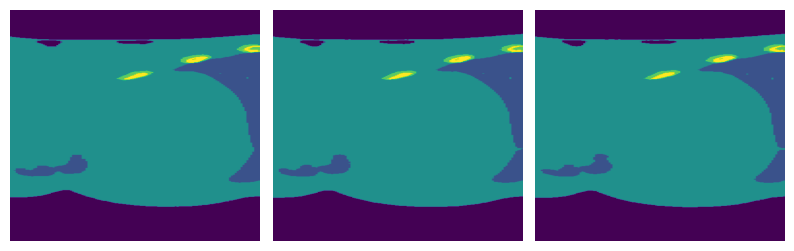

In [14]:
print_3_slices(segmented_classes, 150, 1)

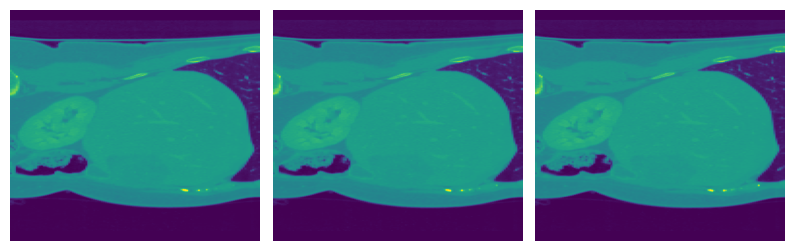

In [15]:
print_3_slices(volume_data, 150, 1)

##### I. 1. b. Coupes coronales

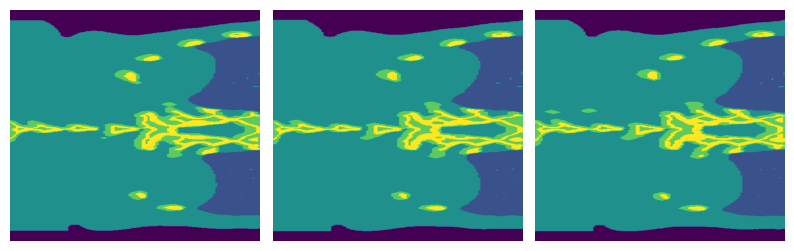

In [16]:
print_3_slices(segmented_classes, 150, 2)

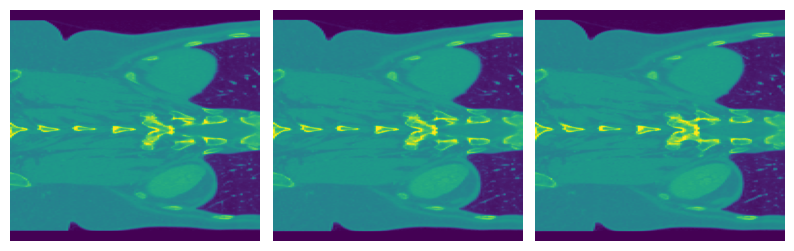

In [17]:
print_3_slices(volume_data, 150, 2)

##### I. 1. c. Coupes axiales

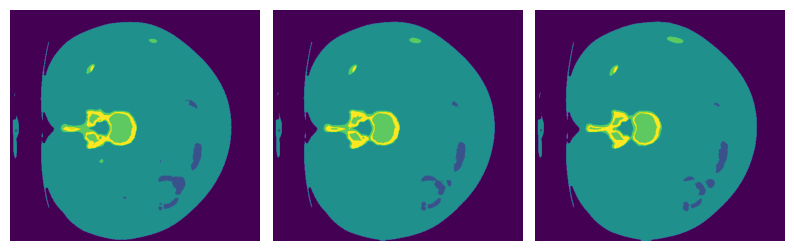

In [18]:
print_3_slices(segmented_classes, 50, 3)

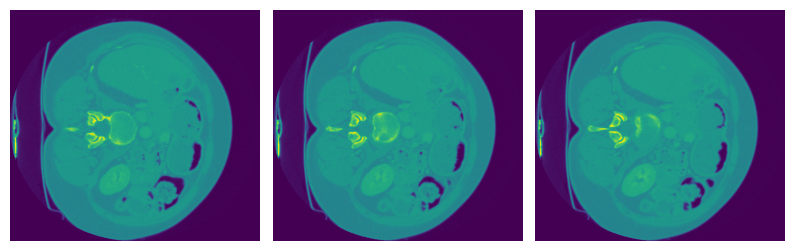

In [19]:
print_3_slices(volume_data, 50, 3)

#### I. 2. Exemples en projection

##### I. 2. a. Projection en vue de côté

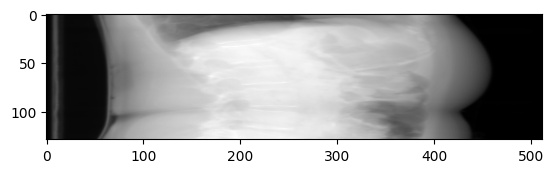

In [20]:
projection = volume_data.sum(axis=0).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

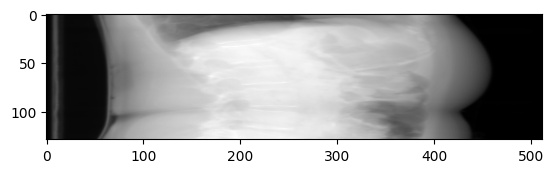

In [21]:
projection_2 = segmented_classes.sum(axis=0).transpose().astype("float64")

height, width = projection_2.shape

projection_2 = np.flipud(projection)

plt.imshow(projection_2, cmap='gray')

##### I. 2. b. Projection en vue de face

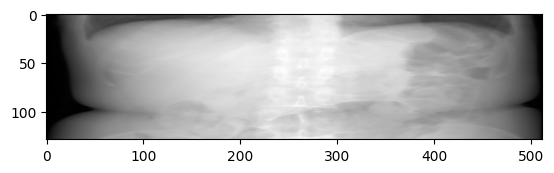

In [22]:
projection = volume_data.sum(axis=1).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

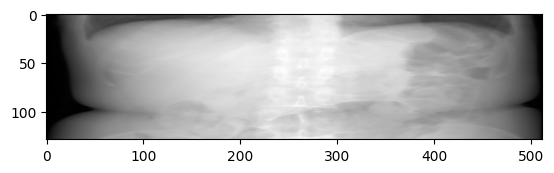

In [23]:
projection_2 = segmented_classes.sum(axis=1).transpose().astype("float64")

height, width = projection_2.shape

projection_2 = np.flipud(projection)

plt.imshow(projection_2, cmap='gray')

##### I. 2. c. Projection en vue de hauteur

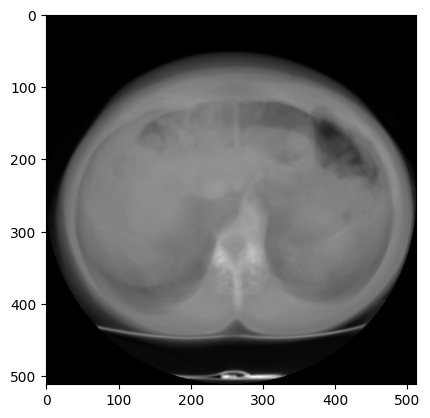

In [24]:
projection = volume_data.sum(axis=2).transpose()

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

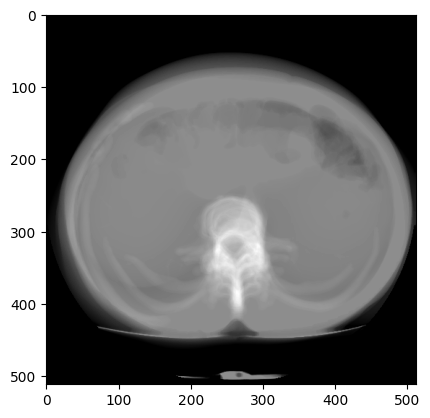

In [25]:
projection_2 = segmented_classes.sum(axis=2).transpose()

new_projection_2 = np.flipud(projection_2)

plt.imshow(new_projection_2, cmap='gray')

#### I. 3. Chargement de l'exemple de classe dans une image 3D

In [26]:
print("loading 3D image of segmented classes ...")
segmented_classes_nii = nib.Nifti1Image(segmented_classes, affine=np.eye(4))
nib.save(segmented_classes_nii, './loaded_3D_image_examples/segmented_classes.nii.gz')
print("finished loading 3D image of segmented classes")

loading 3D image of segmented classes ...
finished loading 3D image of segmented classes


### II. Test de densité

#### II. 1. Exemples en coupe

##### II. 1. a. Coupes sagittales

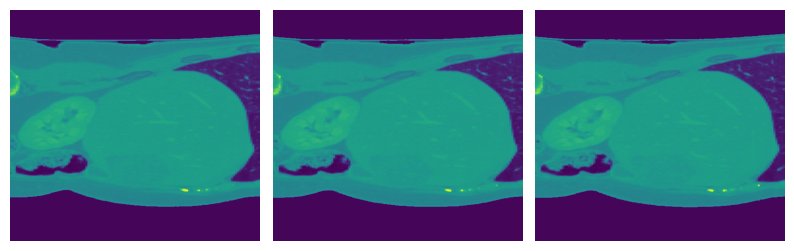

In [27]:
print_3_slices(segmentation.densities(), 150, 1)

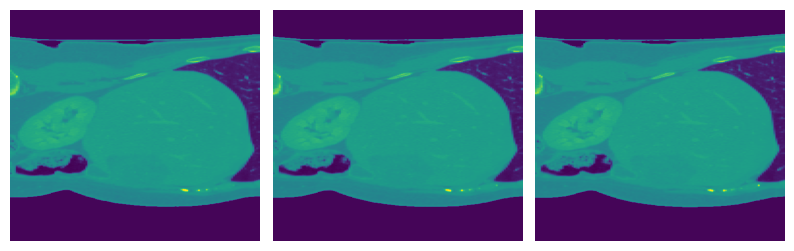

In [28]:
print_3_slices(segmentation.densities(False), 150, 1)

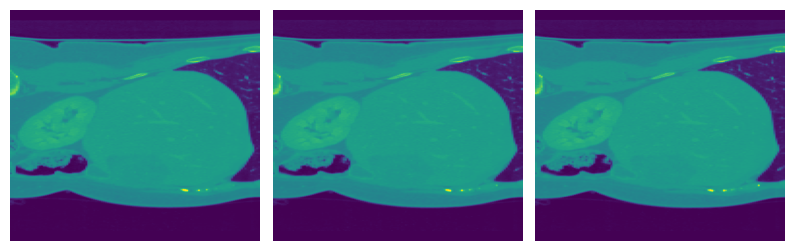

In [29]:
print_3_slices(volume_data, 150, 1)

##### II. 1. b. Coupes coronales

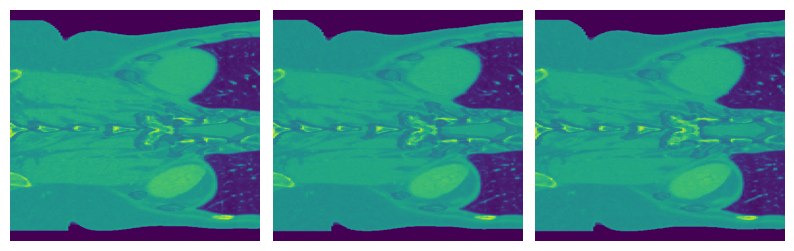

In [30]:
print_3_slices(segmentation.densities(), 150, 2)

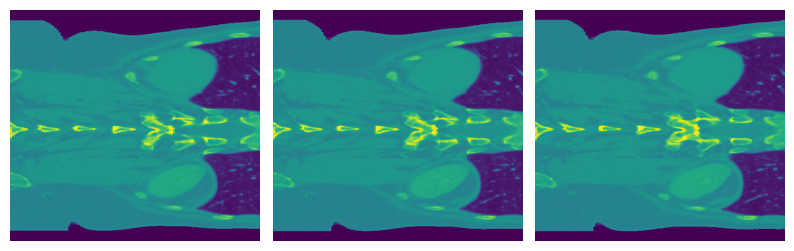

In [31]:
print_3_slices(segmentation.densities(False), 150, 2)

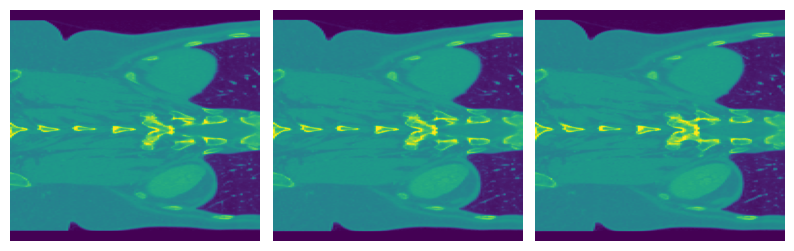

In [32]:
print_3_slices(volume_data, 150, 2)

##### II. 1. c. Coupes axiales

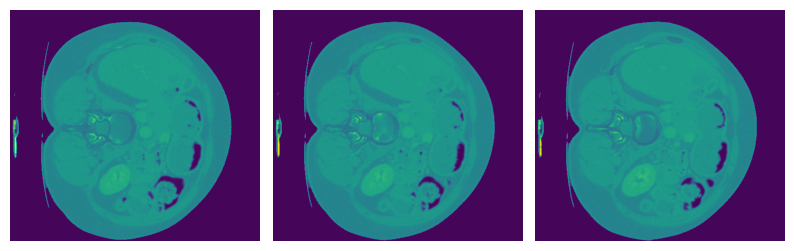

In [33]:
print_3_slices(segmentation.densities(), 50, 3)

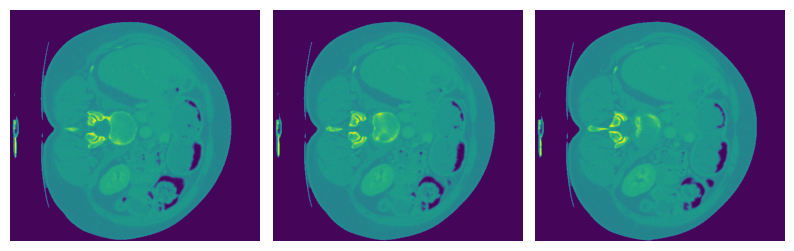

In [34]:
print_3_slices(segmentation.densities(False), 50, 3)

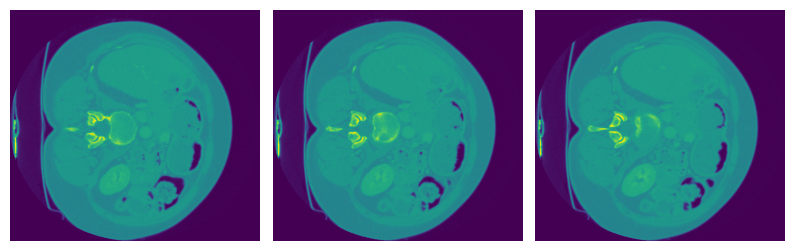

In [35]:
print_3_slices(volume_data, 50, 3)

#### II. 2. Exemples en projection

##### II. 2. a. Projection en vue de côté

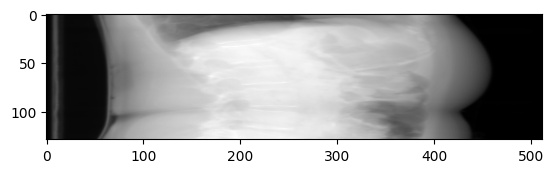

In [36]:
projection = volume_data.sum(axis=0).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

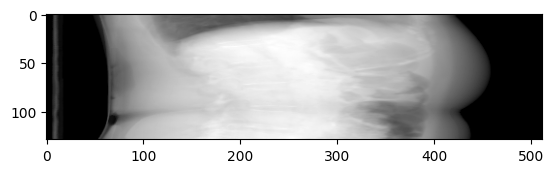

In [37]:
projection_2 = segmentation.densities().sum(axis=0).transpose().astype("float64")

height, width = projection_2.shape

projection_2 = np.flipud(projection_2)

plt.imshow(projection_2, cmap='gray')

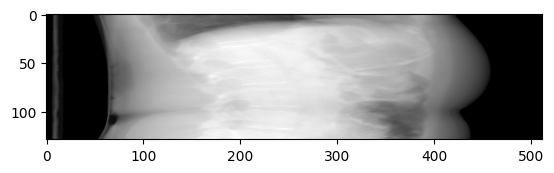

In [38]:
projection_2 = segmentation.densities(False).sum(axis=0).transpose().astype("float64")

height, width = projection_2.shape

projection_2 = np.flipud(projection_2)

plt.imshow(projection_2, cmap='gray')

##### II. 2. b. Projection en vue de face

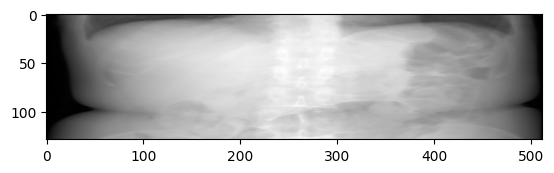

In [39]:
projection = volume_data.sum(axis=1).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

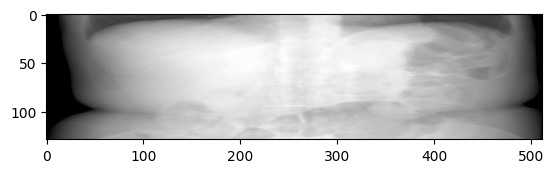

In [40]:
projection_2 = segmentation.densities().sum(axis=1).transpose().astype("float64")

height, width = projection_2.shape

projection_2 = np.flipud(projection_2)

plt.imshow(projection_2, cmap='gray')

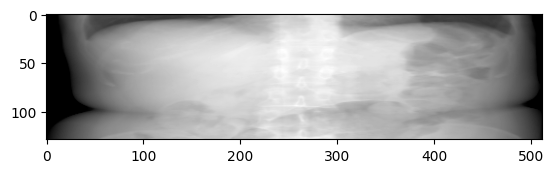

In [41]:
projection_2 = segmentation.densities(False).sum(axis=1).transpose().astype("float64")

height, width = projection_2.shape

projection_2 = np.flipud(projection_2)

plt.imshow(projection_2, cmap='gray')

##### II. 2. c. Projection en vue de hauteur

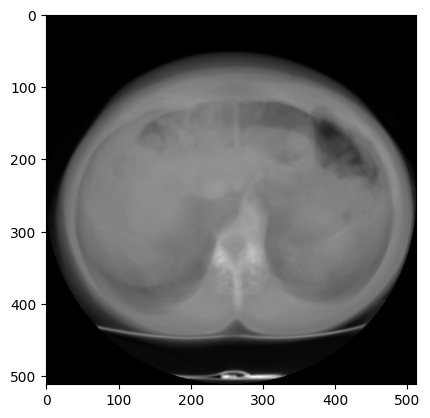

In [42]:
projection = volume_data.sum(axis=2).transpose()

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

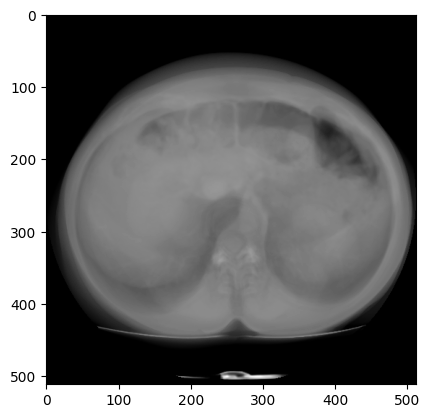

In [43]:
projection_2 = segmentation.densities().sum(axis=2).transpose()

new_projection_2 = np.flipud(projection_2)

plt.imshow(new_projection_2, cmap='gray')

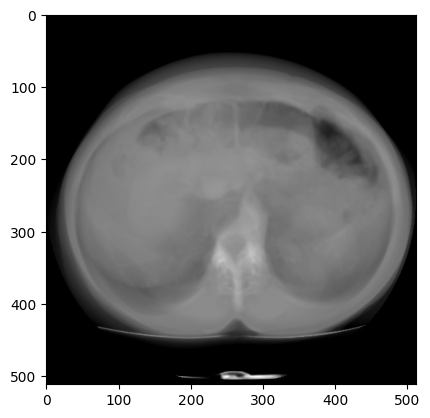

In [44]:
projection_2 = segmentation.densities(False).sum(axis=2).transpose()

new_projection_2 = np.flipud(projection_2)

plt.imshow(new_projection_2, cmap='gray')

#### II. 3. Chargement de l'exemple de densité dans une image 3D

In [45]:
print("loading 3D image of segmented densities ...")
segmented_densities_nii = nib.Nifti1Image(segmentation.densities(), affine=np.eye(4))
nib.save(segmented_densities_nii, './loaded_3D_image_examples/segmented_densities.nii.gz')
print("finished loading 3D image of segmented densities")

loading 3D image of segmented densities ...
finished loading 3D image of segmented densities


In [46]:
print("loading 3D image of segmented attenuations ...")
segmented_densities_nii = nib.Nifti1Image(segmentation.densities(False), affine=np.eye(4))
nib.save(segmented_densities_nii, './loaded_3D_image_examples/segmented_attenuations.nii.gz')
print("finished loading 3D image of segmented attenuations")

loading 3D image of segmented attenuations ...
finished loading 3D image of segmented attenuations


In [47]:
print("loading 3D image of segmented attenuation coeff ...")
segmented_att_coeff_nii = nib.Nifti1Image(segmentation.densities(False), affine=np.eye(4))
nib.save(segmented_att_coeff_nii, './loaded_3D_image_examples/segmented_att_coeff.nii.gz')
print("finished loading 3D image of segmented attenuation coeff")

loading 3D image of segmented attenuation coeff ...
finished loading 3D image of segmented attenuation coeff


### III. Test de position

In [48]:
segmentation.positions[0] * 1000 == volume_nii.header.get_zooms() # voxel size in milimeters

array([ True,  True,  True])

In [49]:
segmented_positions = segmentation.positions

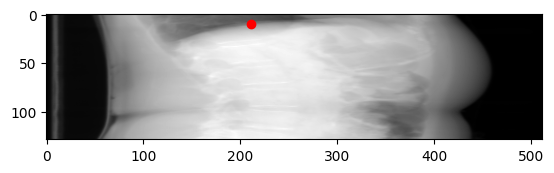

In [50]:
projection = volume_data.sum(axis=0).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

x, y, z = segmented_positions[1]

plt.scatter(y, height - z, color='red', marker='o', label='Dot')

plt.show()

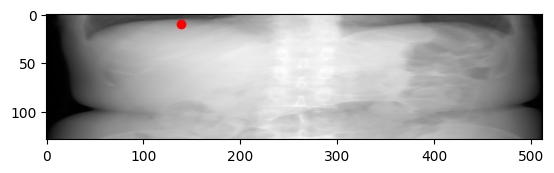

In [51]:
projection = volume_data.sum(axis=1).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(new_projection, cmap='gray')

x, y, z = segmented_positions[1]

plt.scatter(x, height - z, color='red', marker='o', label='Dot')

plt.show()

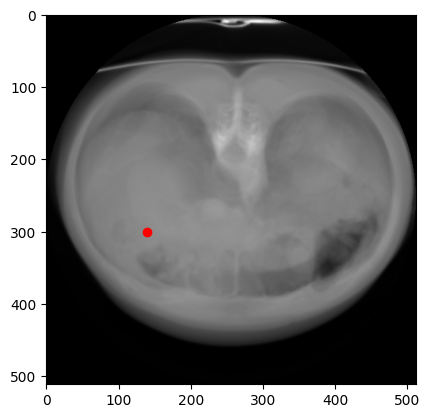

In [52]:
projection = volume_data.sum(axis=2).transpose()

height, width = projection.shape

new_projection = np.flipud(projection)

plt.imshow(projection, cmap='gray')

x, y, z = segmented_positions[1]

plt.scatter(x, height - y, color='red', marker='o', label='Dot')

plt.show()